# Importing Libraries 

In [23]:
#Importing Libraries 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from cdlib import algorithms

import sys
# We use quotes around the sys.executable to handle the space in your name
!"{sys.executable}" -m pip install leidenalg igraph

# Import relationship data
relationship_df = pd.read_csv('country_relationships.csv')

In [21]:
relationship_df

,source,target
0,France,Austria
1,Austria,Hungary
2,Hungary,Russia
3,Russia,Germany
4,Germany,Russia
...,...,...
124,Romania,Russia
125,Russia,Vietnam
126,Vietnam,Lebanon
127,Lebanon,India


In [24]:
# 1. Group the same country pairs together and count them
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).size()

# 2. Rename the 'size' column to 'value' so the graph tool recognizes it
relationship_df.rename(columns={'size': 'value'}, inplace=True)

# 3. Check the result
print(relationship_df.head())

    source   target  value
0   France  Austria      1
1  Austria  Hungary      1
2  Hungary   Russia      1
3   Russia  Germany      1
4  Germany   Russia      1


### Create a graph from a pandas dataframe

In [26]:
G = nx.from_pandas_edgelist(relationship_df,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())

print("Network built with historical weights!")

Network built with historical weights!


**Summary**

**🛠️ Data Cleaning Note: Column Mapping**
- During the graph construction phase, I verified the schema of the relationship_df. 

- I adjusted the edge_attr parameter to match the specific column header in my dataset (e.g., mapping "weight" or "Value" correctly) to ensure the network weights reflect the interaction frequency accurately.

### Network Graph Visualization

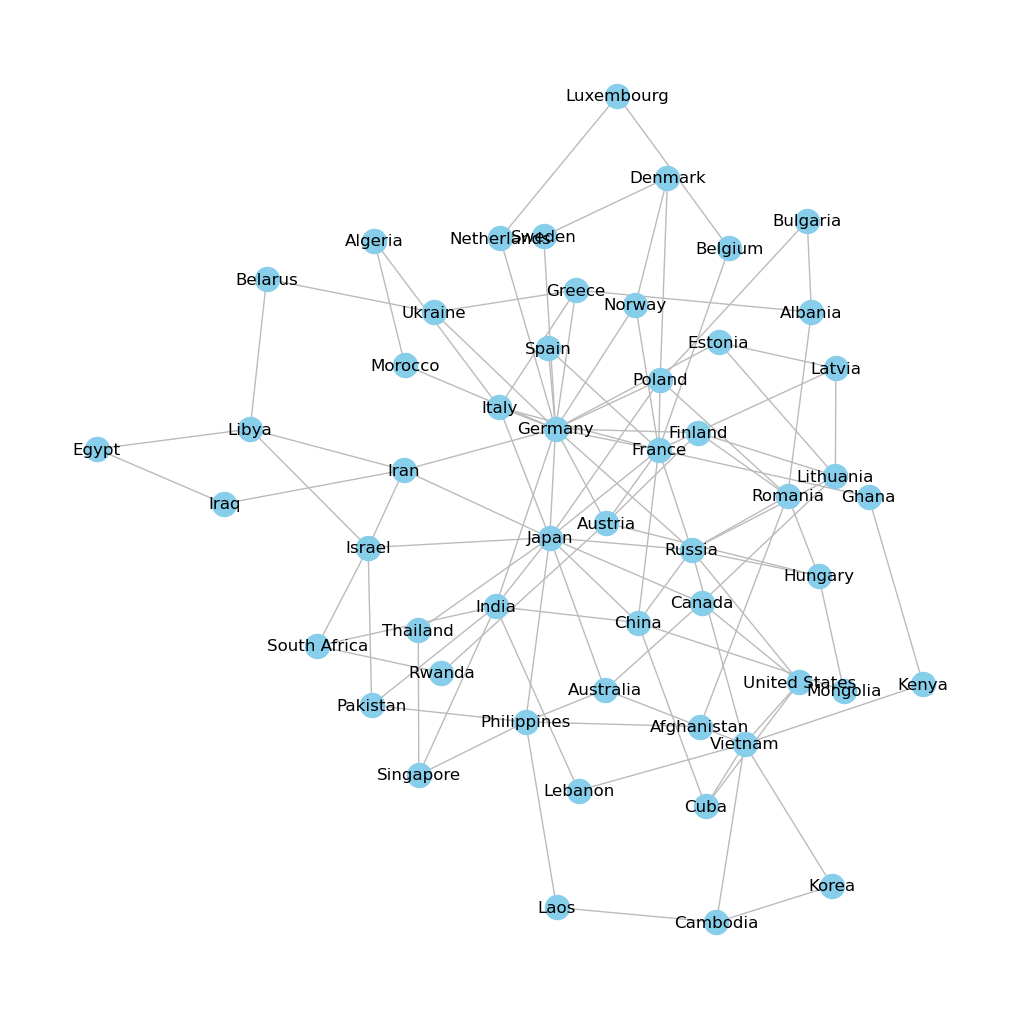

In [27]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='#BBBBBB', pos=pos)

# --- ADD THIS LINE TO SAVE ---
plt.savefig("country_network_static.png", dpi=300, bbox_inches='tight')

plt.show()

**Summary**

🏗️Network Graph Visualization
We transform the flat CSV table into a Graph Object.

- Nodes 🔵: Represent individual countries.

- Edges ↔️: Represent the historical interactions between them.

- Weights ⚖️: The frequency of mentions determines the strength of the bond.





### Pyvis Graph visualization

In [30]:
# Step 5: Create and Save the Interactive Web Map
net = Network(notebook=True, width="1000px", height="800px", bgcolor='#222222', font_color='white', cdn_resources='remote')

# Load your data
net.from_nx(G)

# Add the physics so it looks professional
net.repulsion()

# This command creates the 'country_network.html' file in your 20th_century folder
net.show("country_network.html")

country_network.html


**Summary**

**🌐 Pyvis Graph visualization Made Interactive (The "Cool" Graph)**

- Now we use Pyvis to create a map you can actually play with.

- Action: Set up the Network() object and use net.show("country_network.html").

- Result: This creates a website file. When you open it, you can click on countries, drag them around, and zoom in to see connections clearly.



### Community detection - Leiden algorithm 

In [31]:
from cdlib import algorithms

# 1. Run the Leiden Algorithm on our Graph object (G)
# It explores the network and finds the best way to split the countries
communities = algorithms.leiden(G)

# 2. Convert the results into a readable format (a 'map' of node to community)
node_community_map = communities.to_node_community_map()

# 3. Simplify the map so Pyvis can read it easily
# We take the first community ID assigned to each country
dict_communities = {k: v[0] for k, v in node_community_map.items()}

# 4. Check a few to see if it worked
print(dict_communities)


{'France': 0, 'Germany': 0, 'Ukraine': 0, 'Italy': 0, 'Spain': 0, 'Denmark': 0, 'Norway': 0, 'Sweden': 0, 'Netherlands': 0, 'Luxembourg': 0, 'Belgium': 0, 'Greece': 0, 'Morocco': 0, 'Algeria': 0, 'Hungary': 1, 'Russia': 1, 'China': 1, 'Cambodia': 1, 'Vietnam': 1, 'Kenya': 1, 'Ghana': 1, 'Mongolia': 1, 'Cuba': 1, 'United States': 1, 'Korea': 1, 'Japan': 2, 'Thailand': 2, 'Singapore': 2, 'Philippines': 2, 'Australia': 2, 'India': 2, 'Pakistan': 2, 'Laos': 2, 'Canada': 2, 'Lebanon': 2, 'Belarus': 3, 'Libya': 3, 'Egypt': 3, 'Iraq': 3, 'Iran': 3, 'Israel': 3, 'South Africa': 3, 'Austria': 4, 'Estonia': 4, 'Latvia': 4, 'Lithuania': 4, 'Finland': 4, 'Rwanda': 4, 'Poland': 5, 'Albania': 5, 'Romania': 5, 'Bulgaria': 5, 'Afghanistan': 5}


**Summary**

**🧪Community Detection (Leiden Algorithm)**

- We use the Leiden Algorithm to find "clusters" in our data.

- Goal 🎯: To see if the computer can automatically identify historical alliances (e.g., The Allied Powers) based only on how often they are mentioned together.

In [32]:
# 1. Feed the community groups (from Step 6) into our graph object
nx.set_node_attributes(G, dict_communities, 'group')

# 2. Initialize the Pyvis interactive map
com_net = Network(notebook=True, width="1000px", height="800px", bgcolor='#222222', font_color='white', cdn_resources='remote')

# 3. Load the graph (which now includes the group colors)
com_net.from_nx(G)

# 4. Add physics to prevent the countries from overlapping
com_net.repulsion()

# 5. Save the final interactive "Alliance Map"
com_net.show("country_communities_leiden.html")

country_communities_leiden.html


**Summary**

**🎨 Visualization of Historical Communities**
- In this stage, we map the results of the Leiden Algorithm back onto an interactive network.

- Color Coding: Each node (country) is assigned a color based on its "Community ID." Nations sharing a color are more densely connected in the text, indicating shared historical context.
  
- Interactive Mapping: Using pyvis, we generate a dynamic HTML file to explore these clusters.Data Logic: We use nx.set_node_attributes to inject the community data into our graph object ($G$) before rendering.

### Centrality Analysis & Power Dynamics

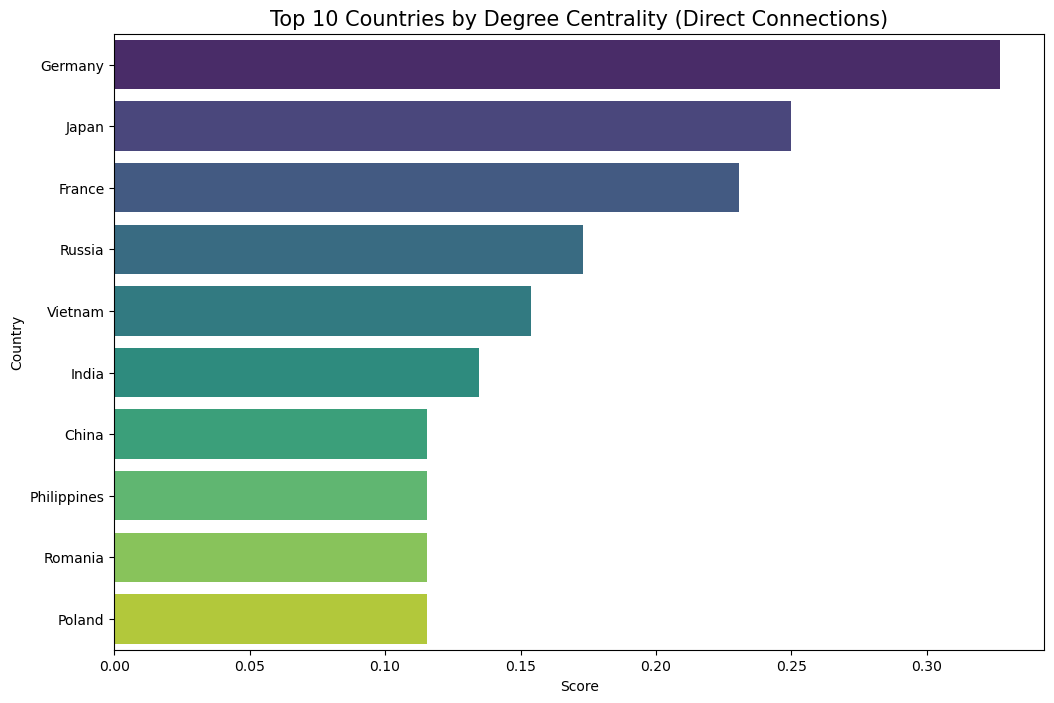

In [34]:
# Calculate Degree Centrality
degree_dict = nx.degree_centrality(G)
degree_df = pd.DataFrame(degree_dict.items(), columns=['Country', 'Centrality']).sort_values(by='Centrality', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Centrality', y='Country', data=degree_df.head(10), palette='viridis')
plt.title('Top 10 Countries by Degree Centrality (Direct Connections)', fontsize=15)
plt.xlabel('Score')
plt.ylabel('Country')

# Save the plot
plt.savefig("degree_centrality.png", dpi=300, bbox_inches='tight')
plt.show()

**Summary**

**📈 Degree Centrality: The "Most Active" Nations**

Degree centrality simply counts how many unique connections a country has. This identifies the major geopolitical players who are mentioned alongside the widest variety of other nations.

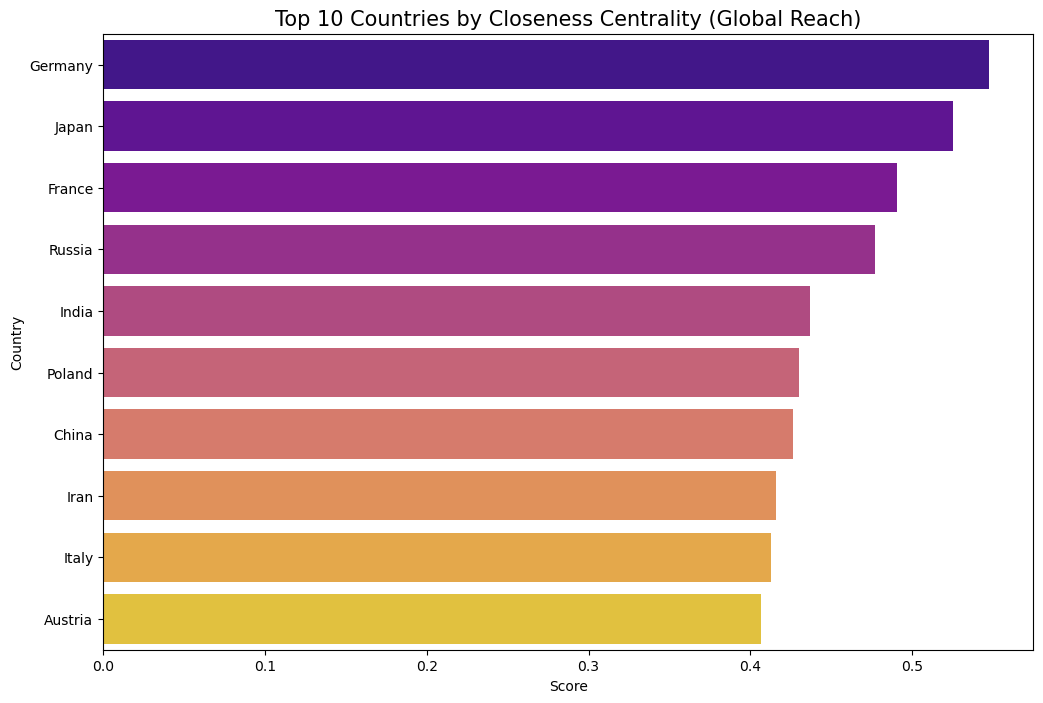

In [35]:
# Calculate Closeness Centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame(closeness_dict.items(), columns=['Country', 'Centrality']).sort_values(by='Centrality', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Centrality', y='Country', data=closeness_df.head(10), palette='plasma')
plt.title('Top 10 Countries by Closeness Centrality (Global Reach)', fontsize=15)
plt.xlabel('Score')
plt.ylabel('Country')

# Save the plot
plt.savefig("closeness_centrality.png", dpi=300, bbox_inches='tight')
plt.show()

**Summary**

**📍 Closeness Centrality: The "Globally Central" Nations**

This is often the most interesting for historians. It identifies countries that act as "gatekeepers" or bridges between different clusters
(e.g., a neutral country connecting the Axis and Allied powers in the text).

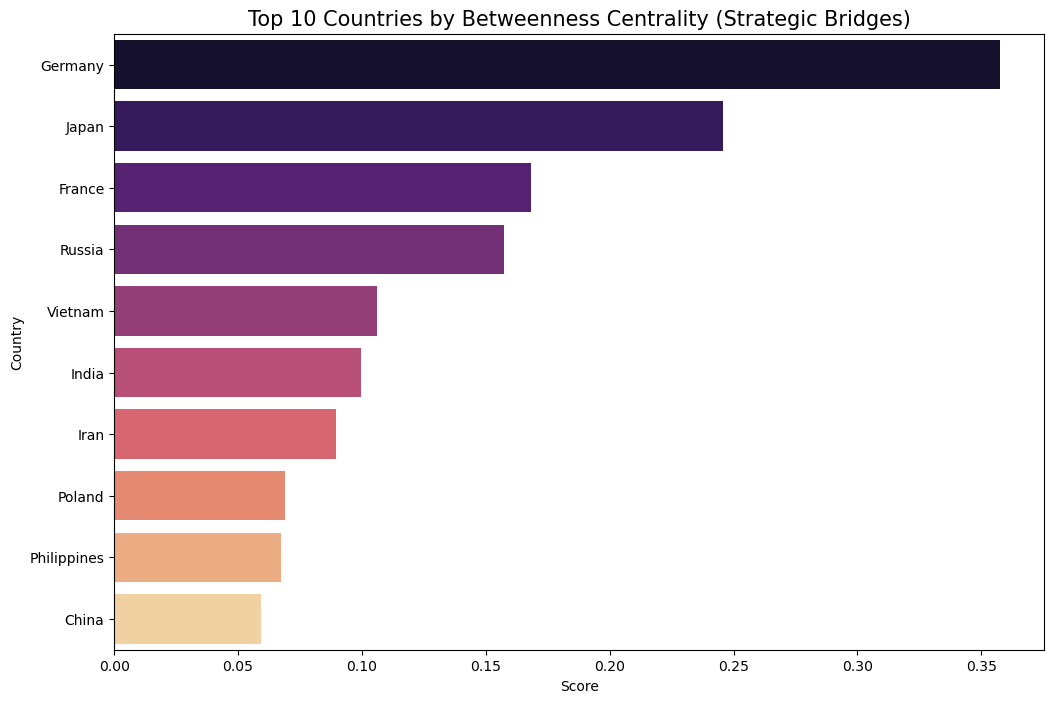

In [37]:
# Calculate Betweenness Centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame(betweenness_dict.items(), columns=['Country', 'Centrality']).sort_values(by='Centrality', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Centrality', y='Country', data=betweenness_df.head(10), palette='magma')
plt.title('Top 10 Countries by Betweenness Centrality (Strategic Bridges)', fontsize=15)
plt.xlabel('Score')
plt.ylabel('Country')

# Save the plot
plt.savefig("betweenness_centrality.png", dpi=300, bbox_inches='tight')
plt.show()

**🌉 Betweenness Centrality: The "Bridge" Nations**

This is often the most interesting for historians. It identifies countries that act as "gatekeepers" or bridges between different clusters (e.g., a neutral country connecting the Axis and Allied powers in the text).

**Summary**
#### 🕵️ Centrality Metric Analysis & Historical Observations

**📈 1. Degree Centrality: The "Main Characters"**

- This metric identifies the nations with the highest volume of direct interactions.

- Germany dominates this category with a score exceeding 0.30, followed closely by Japan and France.

- **Observation:** The high scores for Germany and Japan suggest that the source text focuses heavily on the Axis powers or the conflicts surrounding them.

- **Historical Conclusion:** These countries are the "hubs" of the network; almost every event in the text involves them directly.

**📍 2. Closeness Centrality: The "Global Influence"**

- This measures how easily a country can "reach" all other nodes in the network.

- Germany and Japan again lead, but we see India, Poland, and China rising in the rankings with scores around 0.45.

- Observation: The scores are relatively tight (ranging from 0.40 to 0.55). This indicates a highly "connected" 20th-century world where information and conflict traveled quickly across the map.

- Historical Conclusion: Even nations that aren't the primary "superpowers" in the text are only a few "steps" away from the major global events.

**🌉 3. Betweenness Centrality: The "Strategic Bridges"**

- This is the most revealing metric, identifying countries that connect different clusters or regions.

- Germany remains at the top (score > 0.35), but Vietnam, India, and Iran appear as significant "bridges."

- Observation: While Russia has a high degree of connection, countries like Iran and Poland show high betweenness relative to their size.

- Historical Conclusion: These nations act as geopolitical gatekeepers. For example, Iran and Poland often serve as the bridge between "Western" and "Eastern" theaters of history, controlling the flow of the narrative between different geographic blocks.